# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [14]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [16]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_3358769/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_3358769/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_3358769/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [17]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [18]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [19]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


[I 2025-11-15 18:04:24,955] A new study created in RDB with name: no-name-d093ff71-b64b-46e3-baed-51950d14760e
  0%|          | 2/2000 [00:00<01:49, 18.31it/s]

current_loss: tensor(1.4629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4471358060836792
current_loss: tensor(1.4597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.423617959022522
current_loss: tensor(1.4409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4128555059432983
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.41292142868042
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<01:33, 21.21it/s]

current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4128526449203491
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4128177165985107
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4128037691116333
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4129271507263184
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<01:47, 18.43it/s]


current_loss_val:  1.4133230447769165
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4133639335632324
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4137885570526123
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4134676456451416
Early Stop at iteration 11 with minimal loss tensor(1.4128, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4315, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<03:04, 10.82it/s]

current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3738245964050293
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.330863118171692
current_loss: tensor(1.3690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3540, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:04, 10.80it/s]

current_loss_val:  1.3008697032928467
current_loss: tensor(1.3540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2997874021530151
current_loss: tensor(1.3411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.299524188041687


  0%|          | 6/2000 [00:00<03:07, 10.62it/s]

current_loss: tensor(1.3381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2987101078033447
current_loss: tensor(1.3344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3313, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:29,  9.50it/s]

current_loss_val:  1.297235369682312
current_loss: tensor(1.3313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2957963943481445
current_loss: tensor(1.3290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2938320636749268


  0%|          | 10/2000 [00:00<03:21,  9.90it/s]

current_loss: tensor(1.3264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2894315719604492
current_loss: tensor(1.3219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.280762791633606
current_loss: tensor(1.3198, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:16, 10.12it/s]

current_loss: tensor(1.3147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2801265716552734
current_loss: tensor(1.3147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2796739339828491
current_loss: tensor(1.3135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3105, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:08, 10.51it/s]

current_loss_val:  1.2777968645095825
current_loss: tensor(1.3105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2748655080795288
current_loss: tensor(1.3096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2749184370040894


  1%|          | 18/2000 [00:01<03:06, 10.62it/s]

current_loss: tensor(1.3082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2748628854751587
current_loss: tensor(1.3079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2746191024780273
current_loss: tensor(1.3074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2738198041915894
current_loss: tensor(1.3069, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:01,  8.21it/s]

current_loss: tensor(1.3063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732452154159546
current_loss: tensor(1.3063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717007398605347
current_loss: tensor(1.3054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:30,  9.41it/s]

current_loss_val:  1.2689560651779175
current_loss: tensor(1.3042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659578323364258
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644639015197754


  1%|▏         | 26/2000 [00:02<03:21,  9.80it/s]

current_loss: tensor(1.3021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629177570343018
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608143091201782
current_loss: tensor(1.3010, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:15, 10.10it/s]

current_loss: tensor(1.2998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608176469802856
current_loss: tensor(1.2998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260853886604309
current_loss: tensor(1.2994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2988, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:10, 10.32it/s]

current_loss_val:  1.2609494924545288
current_loss: tensor(1.2988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261669397354126
current_loss: tensor(1.2969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2966, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:26,  9.52it/s]


current_loss_val:  1.2617213726043701
Early Stop at iteration 30 with minimal loss tensor(1.2608, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:04:29,365] Trial 0 finished with value: -2.5216283798217773 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.536731042338257, 'penalty_decorrelation_ridge_second_difference': 26.17455289814254}. Best is trial 0 with value: -2.5216283798217773.
  0%|          | 1/2000 [00:00<04:35,  7.25it/s]

current_loss: tensor(1.2958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607698440551758
current_loss: tensor(1.2947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:30,  9.50it/s]

current_loss_val:  1.2607351541519165
current_loss: tensor(1.2946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602239847183228
current_loss: tensor(1.2933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2595598697662354


  0%|          | 5/2000 [00:00<03:17, 10.12it/s]

current_loss: tensor(1.2930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259662389755249
current_loss: tensor(1.2921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596672773361206
current_loss: tensor(1.2920, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:11, 10.38it/s]

current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596290111541748
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593733072280884
current_loss: tensor(1.2917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2916, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:06, 10.69it/s]

current_loss_val:  1.2592592239379883
current_loss: tensor(1.2916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2590683698654175
current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586482763290405


  1%|          | 13/2000 [00:01<03:04, 10.75it/s]

current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256879448890686
current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552706003189087
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:04, 10.74it/s]

current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546120882034302
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539187669754028
current_loss: tensor(1.2890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:04, 10.76it/s]

current_loss_val:  1.2531120777130127
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251760482788086
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250605821609497


  1%|          | 19/2000 [00:01<03:03, 10.79it/s]

current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501968145370483
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492483854293823


  1%|          | 21/2000 [00:02<03:13, 10.22it/s]

current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248046636581421
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478951215744019
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:10, 10.37it/s]

current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478108406066895
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474995851516724
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:08, 10.50it/s]

current_loss_val:  1.247035264968872
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461045980453491
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:11, 10.32it/s]

current_loss_val:  1.2459158897399902
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458271980285645
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245524525642395


  2%|▏         | 31/2000 [00:02<03:08, 10.46it/s]

current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453001737594604
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452731132507324
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:06, 10.52it/s]

current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452335357666016
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450705766677856
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:05, 10.59it/s]

current_loss_val:  1.2448176145553589
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444380521774292
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441396713256836


  2%|▏         | 37/2000 [00:03<03:04, 10.67it/s]

current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441718578338623
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441895008087158
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<03:02, 10.74it/s]

current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442622184753418
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244347095489502
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<03:11, 10.24it/s]


current_loss_val:  1.2443443536758423
Early Stop at iteration 40 with minimal loss tensor(1.2441, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:04:34,098] Trial 1 finished with value: -2.488279104232788 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.989989233586405, 'penalty_decorrelation_ridge_second_difference': 25.03406015655261}. Best is trial 1 with value: -2.488279104232788.
  0%|          | 1/2000 [00:00<04:19,  7.69it/s]

current_loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606216669082642
current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<04:16,  7.80it/s]

current_loss_val:  1.2597180604934692
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2576696872711182
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:29,  9.50it/s]

current_loss_val:  1.2557427883148193
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548795938491821
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542873620986938


  0%|          | 8/2000 [00:00<03:19, 10.00it/s]

current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538868188858032
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528005838394165
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:31,  9.42it/s]

current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522180080413818
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251858115196228
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:20,  9.91it/s]

current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510104179382324
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250190258026123
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:10, 10.44it/s]

current_loss_val:  1.249496340751648
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491848468780518
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247955083847046


  1%|          | 17/2000 [00:01<03:07, 10.56it/s]

current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464438676834106
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455847263336182
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:06, 10.64it/s]

current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452939748764038
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442731857299805
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:15, 10.12it/s]

current_loss_val:  1.2430564165115356
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424451112747192
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:20,  9.84it/s]

current_loss_val:  1.2421057224273682
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414000034332275
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:31,  9.35it/s]

current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413430213928223
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413157224655151
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:15, 10.10it/s]

current_loss_val:  1.2412598133087158
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241090178489685
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241096019744873


  2%|▏         | 30/2000 [00:03<03:11, 10.30it/s]

current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411028146743774
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411280870437622
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:23,  9.67it/s]


current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411620616912842
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412381172180176
Early Stop at iteration 31 with minimal loss tensor(1.2411, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:04:38,014] Trial 2 finished with value: -2.482180118560791 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.170630887128934, 'penalty_decorrelation_ridge_second_difference': 19.819557558296257}. Best is trial 2 with value: -2.482180118560791.
  0%|          | 2/2000 [00:00<03:09, 10.54it/s]

current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594205141067505
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2580394744873047
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:25,  9.71it/s]

current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557880878448486
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552084922790527
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:16, 10.15it/s]

current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544043064117432
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253291368484497
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:14, 10.22it/s]

current_loss_val:  1.2519686222076416
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250941276550293
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506519556045532


  0%|          | 10/2000 [00:00<03:11, 10.41it/s]

current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506829500198364
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507898807525635
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:08, 10.55it/s]

current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510210275650024
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507495880126953
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:04, 10.73it/s]

current_loss_val:  1.25063955783844
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504451274871826
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250353455543518


  1%|          | 18/2000 [00:01<03:04, 10.75it/s]

current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502244710922241
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500137090682983
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:14, 10.20it/s]

current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249831199645996
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492595911026
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:10, 10.37it/s]

current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483769655227661
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471762895584106


  1%|          | 24/2000 [00:02<04:17,  7.66it/s]

current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462716102600098
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245233416557312


  1%|▏         | 26/2000 [00:02<03:55,  8.40it/s]

current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446516752243042
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432054281234741
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:58,  8.27it/s]

current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243021845817566
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242634892463684
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:40,  8.95it/s]

current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410703897476196
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404710054397583
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:38,  9.01it/s]

current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400861978530884
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240017294883728
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:41,  8.86it/s]

current_loss_val:  1.2397922277450562
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397888898849487
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:53,  8.41it/s]

current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398055791854858
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401658296585083
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:46,  8.65it/s]

current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401963472366333
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402231693267822
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<03:33,  9.20it/s]


current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405318021774292
Early Stop at iteration 38 with minimal loss tensor(1.2398, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:04:42,722] Trial 3 finished with value: -2.4795775413513184 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.221224014712818, 'penalty_decorrelation_ridge_second_difference': 5.612567499484705}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 1/2000 [00:00<04:31,  7.37it/s]

current_loss: tensor(1.3020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260858416557312
current_loss: tensor(1.3007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:36,  9.22it/s]

current_loss_val:  1.261379599571228
current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261853814125061
current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622588872909546


  0%|          | 5/2000 [00:00<04:15,  7.80it/s]


current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624114751815796
current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624536752700806
Early Stop at iteration 5 with minimal loss tensor(1.2609, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:04:43,926] Trial 4 finished with value: -2.521716833114624 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.545719185846902, 'penalty_decorrelation_ridge_second_difference': 28.165424383489423}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 1/2000 [00:00<04:21,  7.65it/s]

current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604701519012451
current_loss: tensor(1.2867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:31,  9.42it/s]

current_loss_val:  1.2577158212661743
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555662393569946
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2533711194992065


  0%|          | 6/2000 [00:00<03:18, 10.02it/s]

current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252732753753662
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252487063407898
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:13, 10.31it/s]

current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525355815887451
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252820372581482
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:37,  9.13it/s]

current_loss_val:  1.2533921003341675
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535430192947388
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253575086593628
Early Stop at iteration 10 with minimal loss tensor(1.2525, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:04:45,592] Trial 5 finished with value: -2.504974126815796 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.6441403510750874, 'penalty_decorrelation_ridge_second_difference': 15.655952692897761}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 2/2000 [00:00<03:06, 10.71it/s]

current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259384274482727
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584267854690552
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:24,  9.75it/s]

current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557545900344849
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254483938217163
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:16, 10.15it/s]

current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2534458637237549
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517436742782593
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:25,  9.72it/s]

current_loss_val:  1.2509702444076538
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504267692565918
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:19,  9.97it/s]

current_loss_val:  1.2502729892730713
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494536638259888
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:48,  8.71it/s]

current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492871284484863
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478923797607422
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:34,  9.26it/s]

current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469691038131714
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463897466659546
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:25,  9.66it/s]

current_loss_val:  1.245363473892212
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449390888214111
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440603971481323


  1%|          | 18/2000 [00:01<03:18,  9.96it/s]

current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243449091911316
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430505752563477
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:14, 10.17it/s]

current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425308227539062
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417616844177246
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:09, 10.45it/s]

current_loss_val:  1.241414189338684
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241370439529419
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411607503890991


  1%|▏         | 26/2000 [00:02<03:17, 10.02it/s]

current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409930229187012
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409495115280151


  1%|▏         | 28/2000 [00:02<03:12, 10.25it/s]

current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240805745124817
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240743637084961
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:09, 10.38it/s]

current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407021522521973
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407426834106445
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:08, 10.43it/s]

current_loss_val:  1.2406610250473022
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406330108642578
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406208515167236


  2%|▏         | 34/2000 [00:03<03:19,  9.85it/s]

current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406539916992188
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:14, 10.10it/s]

current_loss_val:  1.2406270503997803
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406483888626099
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407209873199463


  2%|▏         | 37/2000 [00:03<03:23,  9.67it/s]

current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240747332572937
Early Stop at iteration 37 with minimal loss tensor(1.2406, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:04:50,114] Trial 6 finished with value: -2.4812417030334473 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.997255557276495, 'penalty_decorrelation_ridge_second_difference': 7.023942328403663}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 2/2000 [00:00<03:10, 10.49it/s]

current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596303224563599
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569572925567627
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:11, 10.42it/s]

current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564892768859863
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565510272979736
current_loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:24,  9.73it/s]

current_loss: tensor(1.2867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566051483154297
current_loss: tensor(1.2867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256486177444458
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:17, 10.08it/s]

current_loss_val:  1.2563064098358154
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551069259643555
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529268264770508


  0%|          | 10/2000 [00:00<03:13, 10.29it/s]

current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511003017425537
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514441013336182
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516058683395386
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522011995315552
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:26,  9.63it/s]

current_loss_val:  1.2521545886993408
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521276473999023
Early Stop at iteration 14 with minimal loss tensor(1.2511, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:04:52,218] Trial 7 finished with value: -2.5022003650665283 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.021683930199659, 'penalty_decorrelation_ridge_second_difference': 0.3228137903316317}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 1/2000 [00:00<04:23,  7.60it/s]

current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607437372207642
current_loss: tensor(1.2969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:32,  9.38it/s]

current_loss_val:  1.2603487968444824
current_loss: tensor(1.2957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260192632675171
current_loss: tensor(1.2947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602976560592651


  0%|          | 6/2000 [00:00<03:19,  9.98it/s]

current_loss: tensor(1.2943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260318398475647
current_loss: tensor(1.2940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600950002670288
current_loss: tensor(1.2938, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:14, 10.24it/s]

current_loss: tensor(1.2934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259340763092041
current_loss: tensor(1.2934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583673000335693
current_loss: tensor(1.2931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2928, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:11, 10.37it/s]

current_loss_val:  1.2579541206359863
current_loss: tensor(1.2928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566943168640137
current_loss: tensor(1.2922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548103332519531


  1%|          | 12/2000 [00:01<03:10, 10.46it/s]

current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254204273223877
current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253822922706604
current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:11, 10.39it/s]

current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523847818374634
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517203092575073
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:09, 10.49it/s]

current_loss_val:  1.2512534856796265
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250426173210144
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:13, 10.21it/s]

current_loss_val:  1.2501963376998901
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501500844955444
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498259544372559


  1%|          | 22/2000 [00:02<03:10, 10.38it/s]

current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490966320037842
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487510442733765
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:09, 10.45it/s]

current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485754489898682
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480945587158203
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:07, 10.50it/s]

current_loss_val:  1.2474255561828613
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246712327003479
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246438980102539


  1%|▏         | 28/2000 [00:02<03:06, 10.55it/s]

current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461878061294556
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454811334609985
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:06, 10.59it/s]

current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451205253601074
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451634407043457
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:04, 10.67it/s]

current_loss_val:  1.2452173233032227
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453787326812744
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:17,  9.93it/s]

current_loss_val:  1.2455228567123413
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24561607837677
Early Stop at iteration 34 with minimal loss tensor(1.2451, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:04:56,213] Trial 8 finished with value: -2.490241289138794 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.31468251663988, 'penalty_decorrelation_ridge_second_difference': 13.312065229312056}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 1/2000 [00:00<04:25,  7.52it/s]

current_loss: tensor(1.3028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608678340911865
current_loss: tensor(1.3014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3002, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:34,  9.30it/s]

current_loss_val:  1.2614458799362183
current_loss: tensor(1.3002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620155811309814
current_loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624900341033936


  0%|          | 5/2000 [00:00<04:21,  7.64it/s]

current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626488208770752
current_loss: tensor(1.2979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262681484222412
Early Stop at iteration 5 with minimal loss tensor(1.2609, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:04:57,495] Trial 9 finished with value: -2.521735668182373 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.35297765104953, 'penalty_decorrelation_ridge_second_difference': 29.665693110024367}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 1/2000 [00:00<04:18,  7.73it/s]

current_loss: tensor(1.2999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260749101638794
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260718822479248


  0%|          | 4/2000 [00:00<03:41,  8.99it/s]

current_loss: tensor(1.2987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618962526321411
current_loss: tensor(1.2971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613471746444702


  0%|          | 6/2000 [00:00<03:23,  9.82it/s]

current_loss: tensor(1.2965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261327862739563
current_loss: tensor(1.2964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611218690872192
current_loss: tensor(1.2959, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:16, 10.15it/s]

current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605751752853394
current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599833011627197
current_loss: tensor(1.2953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:13, 10.31it/s]

current_loss_val:  1.258875846862793
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257780909538269
current_loss: tensor(1.2940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568352222442627


  1%|          | 12/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562110424041748
current_loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255155086517334
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:09, 10.48it/s]

current_loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545806169509888
current_loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544643878936768
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:07, 10.55it/s]

current_loss_val:  1.2540050745010376
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540122270584106
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253610372543335


  1%|          | 20/2000 [00:01<03:16, 10.07it/s]

current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253163456916809
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528128623962402


  1%|          | 22/2000 [00:02<03:22,  9.78it/s]

current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251987338066101
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515736818313599


  1%|          | 24/2000 [00:02<03:16, 10.06it/s]

current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511619329452515
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250287652015686
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:13, 10.22it/s]

current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490607500076294
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481220960617065
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:10, 10.34it/s]

current_loss_val:  1.2478597164154053
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468640804290771
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:18,  9.91it/s]

current_loss_val:  1.2467641830444336
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467355728149414
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467000484466553


  2%|▏         | 32/2000 [00:03<03:24,  9.60it/s]

current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466503381729126
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466257810592651


  2%|▏         | 34/2000 [00:03<03:18,  9.92it/s]

current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466665506362915
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468730211257935
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:14, 10.10it/s]

current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247189998626709
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247275710105896
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:19,  9.83it/s]


current_loss_val:  1.247768521308899
Early Stop at iteration 37 with minimal loss tensor(1.2466, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:05:01,864] Trial 10 finished with value: -2.4932518005371094 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.025502759736746, 'penalty_decorrelation_ridge_second_difference': 6.639171091563714}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 1/2000 [00:00<05:10,  6.43it/s]

current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260431170463562
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<04:09,  8.01it/s]

current_loss_val:  1.260106086730957
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564839124679565
current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:31,  9.42it/s]

current_loss_val:  1.255312442779541
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254913091659546
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254157543182373


  0%|          | 8/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535876035690308
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526729106903076
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:16, 10.12it/s]

current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519524097442627
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251633644104004
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:13, 10.29it/s]

current_loss_val:  1.2509480714797974
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501027584075928
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495936155319214


  1%|          | 14/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491925954818726
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24765944480896
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472124099731445
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247254729270935
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:08, 10.54it/s]

current_loss_val:  1.2473459243774414
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473481893539429
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:29,  9.43it/s]

current_loss_val:  1.2473112344741821
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474033832550049
Early Stop at iteration 20 with minimal loss tensor(1.2472, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:05:04,553] Trial 11 finished with value: -2.494424819946289 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.566942828482334, 'penalty_decorrelation_ridge_second_difference': 10.974167468638562}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 2/2000 [00:00<03:09, 10.56it/s]

current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259461760520935
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591174840927124
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:07, 10.62it/s]

current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2585819959640503
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577203512191772
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:23,  9.80it/s]

current_loss_val:  1.2528272867202759
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521734237670898
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:17, 10.11it/s]

current_loss_val:  1.2520253658294678
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513599395751953
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251081109046936


  0%|          | 10/2000 [00:00<03:13, 10.28it/s]

current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250826120376587
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503209114074707
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:10, 10.43it/s]

current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500393390655518
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490781545639038
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:21,  9.84it/s]

current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485859394073486
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482832670211792
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:16, 10.07it/s]

current_loss_val:  1.2458889484405518
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456252574920654
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:18,  9.99it/s]

current_loss_val:  1.2452844381332397
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443252801895142
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432341575622559


  1%|          | 22/2000 [00:02<03:13, 10.21it/s]

current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429150342941284
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242896556854248
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:11, 10.32it/s]

current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428425550460815
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429230213165283
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:21,  9.81it/s]

current_loss_val:  1.2428643703460693
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242923378944397
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:25,  9.59it/s]

current_loss_val:  1.2430027723312378
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430731058120728
Early Stop at iteration 27 with minimal loss tensor(1.2428, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:05:07,952] Trial 12 finished with value: -2.485685348510742 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.7358272598516393, 'penalty_decorrelation_ridge_second_difference': 8.361891573907155}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 1/2000 [00:00<04:20,  7.66it/s]

current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606195211410522
current_loss: tensor(1.2895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:34,  9.29it/s]

current_loss_val:  1.2590157985687256
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2576738595962524
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553516626358032


  0%|          | 6/2000 [00:00<03:20,  9.95it/s]

current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542767524719238
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544465065002441
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:15, 10.20it/s]

current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545181512832642
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547396421432495
current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:43,  8.91it/s]


current_loss_val:  1.2551655769348145
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550746202468872
Early Stop at iteration 9 with minimal loss tensor(1.2543, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:05:09,596] Trial 13 finished with value: -2.5085532665252686 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.236389317645757, 'penalty_decorrelation_ridge_second_difference': 18.62694561367401}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 1/2000 [00:00<04:25,  7.52it/s]

current_loss: tensor(1.2930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605953216552734
current_loss: tensor(1.2923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:35,  9.27it/s]

current_loss_val:  1.2589031457901
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578825950622559
current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569975852966309


  0%|          | 6/2000 [00:00<03:20,  9.93it/s]

current_loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566484212875366
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564018964767456
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:16, 10.16it/s]

current_loss: tensor(1.2890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562620639801025
current_loss: tensor(1.2890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556325197219849
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:13, 10.29it/s]

current_loss_val:  1.2550725936889648
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545889616012573
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538073062896729


  1%|          | 12/2000 [00:01<03:11, 10.37it/s]

current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526875734329224
current_loss: tensor(1.2867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515190839767456
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510217428207397
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483359575271606
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:07, 10.55it/s]

current_loss_val:  1.2471575736999512
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472219467163086
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24734628200531


  1%|          | 20/2000 [00:01<03:16, 10.08it/s]

current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475227117538452
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247725248336792


  1%|          | 20/2000 [00:02<03:26,  9.58it/s]


current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477071285247803
Early Stop at iteration 20 with minimal loss tensor(1.2472, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:05:12,317] Trial 14 finished with value: -2.4943149089813232 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.532542105360587, 'penalty_decorrelation_ridge_second_difference': 12.400765215098703}. Best is trial 3 with value: -2.4795775413513184.
  0%|          | 2/2000 [00:00<03:07, 10.66it/s]

current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25918447971344
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555233240127563
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:07, 10.63it/s]

current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540888786315918
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540429830551147
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:24,  9.76it/s]

current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537293434143066
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531872987747192
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:18, 10.04it/s]

current_loss_val:  1.2527949810028076
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514570951461792
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494099140167236


  0%|          | 10/2000 [00:00<03:14, 10.21it/s]

current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495408058166504
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249420404434204
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:13, 10.27it/s]

current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249277949333191
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489936351776123
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:23,  9.76it/s]

current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486839294433594
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480610609054565
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:13, 10.23it/s]

current_loss_val:  1.2480617761611938
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248080849647522
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479634284973145


  1%|          | 20/2000 [00:01<03:10, 10.38it/s]

current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471052408218384
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460498809814453
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:10, 10.40it/s]

current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457287311553955
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444658279418945
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:19,  9.93it/s]

current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439907789230347
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438167333602905
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:25,  9.62it/s]

current_loss_val:  1.2428525686264038
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424360513687134
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:33,  9.23it/s]

current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421005964279175
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241401195526123
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:35,  9.13it/s]

current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412742376327515
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241148591041565
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:26,  9.54it/s]

current_loss_val:  1.2410752773284912
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409119606018066
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:22,  9.70it/s]

current_loss_val:  1.2408167123794556
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407151460647583
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403813600540161


  2%|▏         | 36/2000 [00:03<03:31,  9.27it/s]

current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240259051322937
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:23,  9.65it/s]

current_loss_val:  1.2401394844055176
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391759157180786
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:23,  9.63it/s]

current_loss_val:  1.2391350269317627
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391064167022705
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2390203475952148


  2%|▏         | 43/2000 [00:04<03:16,  9.97it/s]

current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238799810409546
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2387694120407104
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:16,  9.95it/s]

current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2387644052505493
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2388049364089966
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:11, 10.22it/s]

current_loss_val:  1.2389190196990967
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238932728767395
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:05<03:24,  9.55it/s]

current_loss_val:  1.2389404773712158
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389451265335083
Early Stop at iteration 48 with minimal loss tensor(1.2388, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:05:18,022] Trial 15 finished with value: -2.4775285720825195 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.0200169267111159, 'penalty_decorrelation_ridge_second_difference': 3.591184844073259}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 1/2000 [00:00<08:19,  4.01it/s]

current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591633796691895
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536693811416626


  0%|          | 2/2000 [00:00<08:56,  3.72it/s]

current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<10:31,  3.16it/s]

current_loss_val:  1.2519842386245728
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<12:47,  2.60it/s]

current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519856691360474
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<14:44,  2.25it/s]

current_loss_val:  1.2524434328079224
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<13:29,  2.46it/s]

current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252685546875
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<10:58,  3.02it/s]

current_loss_val:  1.2523250579833984
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<09:50,  3.37it/s]

current_loss_val:  1.251890778541565
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:55,  3.71it/s]

current_loss_val:  1.2515416145324707
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251267910003662


  1%|          | 11/2000 [00:03<07:57,  4.16it/s]

current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25032639503479
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<08:04,  4.10it/s]

current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496681213378906
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<06:59,  4.74it/s]

current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489770650863647
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<07:19,  4.52it/s]

current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474348545074463
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<07:09,  4.62it/s]

current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449321746826172
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<07:29,  4.41it/s]

current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442301511764526
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<07:30,  4.40it/s]

current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244227409362793
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<07:16,  4.54it/s]

current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442924976348877
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<07:48,  4.23it/s]

current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448391914367676
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<10:01,  3.29it/s]

current_loss_val:  1.2466124296188354
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:06<11:36,  2.84it/s]

current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459098100662231


  1%|          | 21/2000 [00:06<10:01,  3.29it/s]

current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245746374130249
Early Stop at iteration 21 with minimal loss tensor(1.2442, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:05:25,126] Trial 16 finished with value: -2.488454580307007 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.1483324314506937, 'penalty_decorrelation_ridge_second_difference': 0.04537731343088147}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 1/2000 [00:00<05:56,  5.60it/s]

current_loss: tensor(1.2943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260059118270874
current_loss: tensor(1.2934, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<06:20,  5.25it/s]

current_loss: tensor(1.2930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259122371673584
current_loss: tensor(1.2930, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<06:40,  4.99it/s]

current_loss: tensor(1.2925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586569786071777
current_loss: tensor(1.2925, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<07:00,  4.75it/s]

current_loss: tensor(1.2920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583250999450684
current_loss: tensor(1.2920, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<06:55,  4.80it/s]

current_loss: tensor(1.2914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2576037645339966
current_loss: tensor(1.2914, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:07,  4.66it/s]

current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573565244674683
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<05:23,  6.15it/s]

current_loss_val:  1.257001519203186
current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25704026222229
current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570991516113281


  0%|          | 10/2000 [00:01<04:18,  7.70it/s]

current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572258710861206
current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569363117218018
current_loss: tensor(1.2900, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:50,  8.62it/s]

current_loss: tensor(1.2898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256754755973816
current_loss: tensor(1.2898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565544843673706
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<03:31,  9.41it/s]

current_loss_val:  1.256501317024231
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256358027458191
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557713985443115


  1%|          | 18/2000 [00:02<03:28,  9.51it/s]

current_loss: tensor(1.2888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552067041397095
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549582719802856


  1%|          | 19/2000 [00:02<03:28,  9.52it/s]

current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544147968292236
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:34,  7.21it/s]

current_loss: tensor(1.2898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541922330856323
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538933753967285
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:56,  8.38it/s]

current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523118257522583
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500925064086914
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<03:47,  8.68it/s]

current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248591423034668
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478156089782715
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<03:44,  8.81it/s]

current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453488111495972
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447549104690552
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<03:52,  8.47it/s]

current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444531917572021
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<03:35,  9.13it/s]

current_loss_val:  1.2449325323104858
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446064949035645
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445573806762695


  2%|▏         | 32/2000 [00:04<04:19,  7.58it/s]

current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244504690170288
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244580864906311
Early Stop at iteration 32 with minimal loss tensor(1.2445, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:05:29,986] Trial 17 finished with value: -2.488906145095825 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.994796033269136, 'penalty_decorrelation_ridge_second_difference': 0.4226375078981164}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 2/2000 [00:00<03:11, 10.41it/s]

current_loss: tensor(1.2923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599499225616455
current_loss: tensor(1.2919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259872317314148
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:09, 10.56it/s]

current_loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2597415447235107
current_loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592891454696655
current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:26,  9.68it/s]

current_loss_val:  1.2574511766433716
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566304206848145
current_loss: tensor(1.2888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:20,  9.95it/s]

current_loss_val:  1.2563337087631226
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543238401412964
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539474964141846


  0%|          | 10/2000 [00:00<03:16, 10.11it/s]

current_loss: tensor(1.2879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538378238677979
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538899183273315
current_loss: tensor(1.2875, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:12, 10.31it/s]

current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541937828063965
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545642852783203
current_loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:55,  8.45it/s]

current_loss_val:  1.2546474933624268
current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254716157913208
Early Stop at iteration 14 with minimal loss tensor(1.2538, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:05:32,249] Trial 18 finished with value: -2.5076756477355957 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.775124221374362, 'penalty_decorrelation_ridge_second_difference': 6.139603114217417}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 1/2000 [00:00<04:26,  7.49it/s]

current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603133916854858
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:13,  7.87it/s]

current_loss_val:  1.2566181421279907
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540383338928223
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:48,  8.74it/s]

current_loss_val:  1.2522708177566528
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251660704612732
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251307725906372


  0%|          | 7/2000 [00:00<03:32,  9.38it/s]

current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508870363235474
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503209114074707
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:24,  9.76it/s]

current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498582601547241
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490516901016235
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:28,  9.55it/s]

current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486929893493652
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485005855560303
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:32,  9.35it/s]

current_loss_val:  1.2475937604904175
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247341513633728
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:24,  9.70it/s]

current_loss_val:  1.2471473217010498
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451685667037964
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:32,  9.31it/s]

current_loss_val:  1.2447140216827393
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445132732391357
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438230514526367


  1%|          | 20/2000 [00:02<03:22,  9.77it/s]

current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432942390441895
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429465055465698
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:17, 10.00it/s]

current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242624044418335
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423193454742432
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:14, 10.18it/s]

current_loss_val:  1.242159366607666
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24187433719635
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417527437210083


  1%|▏         | 27/2000 [00:02<03:12, 10.25it/s]

current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411470413208008
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407575845718384
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:13, 10.19it/s]

current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404232025146484
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402561902999878
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:09, 10.37it/s]

current_loss_val:  1.2401201725006104
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400425672531128
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398879528045654


  2%|▏         | 35/2000 [00:03<03:08, 10.44it/s]

current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398446798324585
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397031784057617
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:18,  9.89it/s]

current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396475076675415
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396059036254883
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:30,  9.32it/s]

current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394897937774658
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394826412200928
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:20,  9.76it/s]

current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394523620605469
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239389181137085
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:16,  9.97it/s]

current_loss_val:  1.239306926727295
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393245697021484
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393304109573364


  2%|▏         | 45/2000 [00:04<03:13, 10.10it/s]

current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394013404846191
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394485473632812
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:24,  9.55it/s]


current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395031452178955
Early Stop at iteration 46 with minimal loss tensor(1.2393, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:05:37,695] Trial 19 finished with value: -2.47861385345459 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.24984074957712776, 'penalty_decorrelation_ridge_second_difference': 14.707579078663555}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 1/2000 [00:00<04:38,  7.19it/s]

current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606722116470337
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605458498001099


  0%|          | 3/2000 [00:00<03:32,  9.42it/s]

current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258634328842163
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255360722541809
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:21,  9.92it/s]

current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540122270584106
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253786325454712
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:15, 10.20it/s]

current_loss_val:  1.2536543607711792
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2534798383712769
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531559467315674


  0%|          | 10/2000 [00:01<03:14, 10.26it/s]

current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525906562805176
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515491247177124
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:11, 10.37it/s]

current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508578300476074
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250917673110962
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:11, 10.40it/s]

current_loss_val:  1.2510170936584473
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512171268463135
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:32,  9.35it/s]

current_loss_val:  1.2512617111206055
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251260757446289
Early Stop at iteration 16 with minimal loss tensor(1.2509, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:05:40,046] Trial 20 finished with value: -2.501715660095215 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.0558177595058242, 'penalty_decorrelation_ridge_second_difference': 27.27282737005774}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 1/2000 [00:00<04:23,  7.58it/s]

current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600256204605103
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593488693237305


  0%|          | 3/2000 [00:00<05:46,  5.76it/s]

current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254001259803772
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:12,  7.89it/s]

current_loss_val:  1.2526193857192993
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523921728134155
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517359256744385


  0%|          | 8/2000 [00:01<03:45,  8.82it/s]

current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512246370315552
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506953477859497
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:33,  9.33it/s]

current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501848936080933
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249226450920105
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:45,  8.81it/s]

current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248807430267334
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484849691390991
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:29,  9.48it/s]

current_loss_val:  1.2473747730255127
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466089725494385
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458831071853638


  1%|          | 16/2000 [00:01<03:22,  9.80it/s]

current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457845211029053
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453728914260864
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<03:16, 10.06it/s]

current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244909644126892
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244362711906433
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:13, 10.22it/s]

current_loss_val:  1.2442905902862549
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442317008972168
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442070245742798


  1%|          | 24/2000 [00:02<03:11, 10.32it/s]

current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441272735595703
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441742420196533
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442346811294556
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244214653968811


  1%|▏         | 28/2000 [00:03<03:24,  9.66it/s]

current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441736459732056
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243994951248169
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:28,  9.43it/s]

current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437936067581177
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437182664871216
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:23,  9.67it/s]

current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437024116516113
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435306310653687
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:19,  9.84it/s]

current_loss_val:  1.2433677911758423
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430987358093262
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430377006530762


  2%|▏         | 36/2000 [00:03<03:17,  9.95it/s]

current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425702810287476
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<03:27,  9.45it/s]

current_loss_val:  1.2425429821014404
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424019575119019
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418619394302368


  2%|▏         | 40/2000 [00:04<03:21,  9.75it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413628101348877
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:22,  9.65it/s]

current_loss_val:  1.2409989833831787
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407810688018799
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402348518371582


  2%|▏         | 44/2000 [00:04<03:33,  9.16it/s]

current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240017056465149
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:25,  9.52it/s]

current_loss_val:  1.2397884130477905
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239625096321106
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239343285560608
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:05<04:08,  7.85it/s]

current_loss_val:  1.2392209768295288
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392138242721558
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:05<03:38,  8.90it/s]

current_loss_val:  1.2392572164535522
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393230199813843
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393653392791748


  3%|▎         | 53/2000 [00:05<03:36,  9.00it/s]


current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393745183944702
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393590211868286
Early Stop at iteration 53 with minimal loss tensor(1.2392, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:05:46,596] Trial 21 finished with value: -2.4784271717071533 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7678252783582701, 'penalty_decorrelation_ridge_second_difference': 11.033146611776042}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 1/2000 [00:00<04:24,  7.57it/s]

current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260085940361023
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594575881958008


  0%|          | 3/2000 [00:00<03:28,  9.57it/s]

current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253962516784668
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:36,  9.23it/s]

current_loss_val:  1.2524739503860474
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522754669189453
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516597509384155


  0%|          | 8/2000 [00:00<03:24,  9.75it/s]

current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511823177337646
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507838010787964
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:24,  9.71it/s]

current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25016188621521
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494451999664307
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:25,  9.65it/s]

current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487950325012207
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484688758850098
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:29,  9.49it/s]

current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470483779907227
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465612888336182
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:22,  9.77it/s]

current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464262247085571
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464537620544434
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:22,  9.78it/s]

current_loss_val:  1.246517300605774
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466446161270142
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464478015899658


  1%|          | 19/2000 [00:02<03:36,  9.16it/s]


current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246439814567566
Early Stop at iteration 19 with minimal loss tensor(1.2464, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:05:49,361] Trial 22 finished with value: -2.492851972579956 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.3865550042084477, 'penalty_decorrelation_ridge_second_difference': 11.783060333262988}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 1/2000 [00:00<04:26,  7.50it/s]

current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26039719581604
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:55,  8.47it/s]

current_loss_val:  1.2584854364395142
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545926570892334
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523741722106934


  0%|          | 5/2000 [00:00<03:30,  9.49it/s]

current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252076268196106
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520232200622559
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:21,  9.86it/s]

current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519888877868652
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520939111709595
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:16, 10.14it/s]

current_loss_val:  1.2522828578948975
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523738145828247
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252340316772461


  1%|          | 12/2000 [00:01<03:15, 10.19it/s]

current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517189979553223
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512892484664917


  1%|          | 14/2000 [00:01<03:14, 10.19it/s]

current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511272430419922
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502226829528809
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:12, 10.30it/s]

current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477495670318604
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465354204177856
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:12, 10.30it/s]

current_loss_val:  1.2457666397094727
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442435026168823
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430146932601929


  1%|          | 22/2000 [00:02<03:10, 10.38it/s]

current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426941394805908
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426162958145142
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:11, 10.33it/s]

current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242325782775879
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421622276306152
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:11, 10.31it/s]

current_loss_val:  1.242038607597351
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420564889907837
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420287132263184


  1%|▏         | 28/2000 [00:02<03:11, 10.28it/s]

current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419859170913696
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241969108581543
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:10, 10.36it/s]

current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419542074203491
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420334815979004
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:10, 10.32it/s]

current_loss_val:  1.2421187162399292
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423596382141113
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429429292678833


  2%|▏         | 34/2000 [00:03<03:20,  9.82it/s]


current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427725791931152
Early Stop at iteration 34 with minimal loss tensor(1.2420, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:05:53,494] Trial 23 finished with value: -2.483908176422119 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2174817216657485, 'penalty_decorrelation_ridge_second_difference': 15.653942231199759}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 1/2000 [00:00<04:28,  7.46it/s]

current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604496479034424
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:03,  8.19it/s]

current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2581781148910522
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254762053489685
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:36,  9.20it/s]

current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518982887268066
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517592906951904
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:26,  9.63it/s]

current_loss_val:  1.2516623735427856
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516461610794067
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516928911209106


  0%|          | 9/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522433996200562
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523952722549438


  1%|          | 11/2000 [00:01<03:47,  8.74it/s]

current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523951530456543
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523304224014282
Early Stop at iteration 11 with minimal loss tensor(1.2516, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:05:55,406] Trial 24 finished with value: -2.5032923221588135 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.25503669405898155, 'penalty_decorrelation_ridge_second_difference': 17.73600618904026}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 2/2000 [00:00<03:16, 10.16it/s]

current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592464685440063
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258299469947815
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:14, 10.28it/s]

current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551769018173218
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531232833862305
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 6/2000 [00:00<03:18, 10.04it/s]

tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514290809631348
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251243233680725
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:16, 10.11it/s]

current_loss_val:  1.2507623434066772
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505738735198975
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504242658615112


  0%|          | 10/2000 [00:00<03:15, 10.16it/s]

current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503811120986938
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498382329940796
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:14, 10.24it/s]

current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494196891784668
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490953207015991
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:14, 10.23it/s]

current_loss_val:  1.248258352279663
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476166486740112
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471129894256592


  1%|          | 18/2000 [00:01<03:11, 10.34it/s]

current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468091249465942
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465004920959473
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:12, 10.30it/s]

current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458997964859009
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448290586471558
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:12, 10.28it/s]

current_loss_val:  1.2437982559204102
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434316873550415
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427968978881836


  1%|          | 24/2000 [00:02<03:13, 10.24it/s]

current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422094345092773
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419703006744385
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:11, 10.31it/s]

current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418960332870483
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417421340942383
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:22,  9.75it/s]

current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417842149734497
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421259880065918
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:14, 10.10it/s]

current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420647144317627
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242042064666748
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:20,  9.81it/s]


current_loss_val:  1.2419531345367432
Early Stop at iteration 31 with minimal loss tensor(1.2417, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:05:59,223] Trial 25 finished with value: -2.4834840297698975 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.016285039503920906, 'penalty_decorrelation_ridge_second_difference': 8.440046248733916}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 2/2000 [00:00<03:09, 10.52it/s]

current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591040134429932
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253678321838379
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:29,  9.51it/s]

current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518271207809448
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518153190612793
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:23,  9.82it/s]

current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522332668304443
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524563074111938
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:20,  9.94it/s]

current_loss_val:  1.2519900798797607
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251491665840149
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511050701141357


  0%|          | 10/2000 [00:01<03:19,  9.99it/s]

current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250802755355835
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496013641357422
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:28,  9.51it/s]

current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489042282104492
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475429773330688
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:24,  9.72it/s]

current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448266744613647
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446504831314087
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:19,  9.96it/s]

current_loss_val:  1.2434645891189575
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432383298873901
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:47,  8.71it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24281907081604
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425769567489624
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:33,  9.26it/s]

current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242243766784668
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418149709701538
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:26,  9.55it/s]

current_loss_val:  1.2417455911636353
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241412878036499
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:34,  9.19it/s]

current_loss_val:  1.2413955926895142
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414366006851196
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416191101074219


  1%|▏         | 27/2000 [00:02<03:24,  9.66it/s]

current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415833473205566
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408223152160645
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:31,  9.30it/s]

current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405143976211548
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405380010604858
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:23,  9.69it/s]

current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407265901565552
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406343221664429
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:20,  9.79it/s]

current_loss_val:  1.240386724472046
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403284311294556
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402576208114624


  2%|▏         | 36/2000 [00:03<03:13, 10.14it/s]

current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400867938995361
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400517463684082
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:26,  9.51it/s]

current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239985466003418
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398892641067505
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:38,  8.98it/s]

current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399019002914429
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399235963821411
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:25,  9.52it/s]

current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399908304214478
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399590015411377
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<03:18,  9.87it/s]

current_loss_val:  1.2398552894592285
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398126125335693
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397578954696655


  2%|▏         | 47/2000 [00:04<03:16,  9.93it/s]

current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396652698516846
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396373748779297


  2%|▏         | 49/2000 [00:05<03:15,  9.99it/s]

current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397010326385498
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398089170455933
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:05<03:11, 10.15it/s]

current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397421598434448
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397180795669556
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:05<03:25,  9.48it/s]

current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396479845046997
Early Stop at iteration 52 with minimal loss tensor(1.2396, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:06:05,380] Trial 26 finished with value: -2.4792747497558594 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.881774704929143, 'penalty_decorrelation_ridge_second_difference': 0.5752661143393749}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 1/2000 [00:00<04:24,  7.55it/s]

current_loss: tensor(1.2898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604559659957886
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2601499557495117


  0%|          | 3/2000 [00:00<03:31,  9.46it/s]

current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256388545036316
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:33,  9.33it/s]

current_loss_val:  1.2551997900009155
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546517848968506
current_loss: tensor(1.2859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539916038513184


  0%|          | 8/2000 [00:00<03:23,  9.80it/s]

current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2533743381500244
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524614334106445
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:22,  9.82it/s]

current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520015239715576
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517836093902588
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:21,  9.87it/s]

current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509286403656006
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502052783966064
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:14, 10.19it/s]

current_loss_val:  1.2499406337738037
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493457794189453
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482383251190186


  1%|          | 16/2000 [00:01<03:17, 10.06it/s]

current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469393014907837
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460840940475464
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:14, 10.20it/s]

current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245526909828186
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443476915359497
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:14, 10.19it/s]

current_loss_val:  1.244003176689148
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429004907608032
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428213357925415


  1%|          | 24/2000 [00:02<03:13, 10.24it/s]

current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427732944488525
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242557168006897
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:13, 10.20it/s]

current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423858642578125
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423521280288696
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:13, 10.19it/s]

current_loss_val:  1.2423977851867676
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425209283828735
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:21,  9.78it/s]

current_loss_val:  1.2424709796905518
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424821853637695
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:26,  9.54it/s]


current_loss_val:  1.2425293922424316
Early Stop at iteration 30 with minimal loss tensor(1.2424, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:06:09,155] Trial 27 finished with value: -2.48470401763916 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.917474959070285, 'penalty_decorrelation_ridge_second_difference': 11.99073651068873}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 2/2000 [00:00<03:07, 10.65it/s]

current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592735290527344
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584460973739624
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:09, 10.54it/s]

current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558882236480713
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538295984268188
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:28,  9.57it/s]

current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520521879196167
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512788772583008
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:23,  9.78it/s]

current_loss_val:  1.2509033679962158
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500218152999878
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249701738357544


  0%|          | 10/2000 [00:01<03:22,  9.85it/s]

current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493669986724854
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493040561676025
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:17, 10.07it/s]

current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491137981414795
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248566746711731
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:16, 10.10it/s]

current_loss_val:  1.2480279207229614
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479382753372192
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478384971618652


  1%|          | 18/2000 [00:01<03:13, 10.22it/s]

current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476763725280762
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476822137832642
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:14, 10.20it/s]

current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477266788482666
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475347518920898
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:14, 10.15it/s]

current_loss_val:  1.2473472356796265
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465955018997192
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:24,  9.65it/s]

current_loss_val:  1.2463017702102661
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460676431655884
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452385425567627


  1%|▏         | 26/2000 [00:02<03:21,  9.78it/s]

current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448145151138306
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244166612625122
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:17,  9.99it/s]

current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440625429153442
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440727949142456
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:15, 10.06it/s]

current_loss_val:  1.244006633758545
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441322803497314
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441126108169556


  2%|▏         | 34/2000 [00:03<03:12, 10.19it/s]

current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440457344055176
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438191175460815
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:13, 10.16it/s]

current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243700623512268
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24356210231781
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:13, 10.14it/s]

current_loss_val:  1.2434585094451904
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243442416191101
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433326244354248


  2%|▏         | 40/2000 [00:03<03:13, 10.11it/s]

current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243140459060669
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426561117172241
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:12, 10.20it/s]

current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24222731590271
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420473098754883
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<03:34,  9.10it/s]

current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241602897644043
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241439700126648
current_loss: 

  2%|▏         | 46/2000 [00:04<03:44,  8.70it/s]

tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409957647323608
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:04<03:44,  8.68it/s]

current_loss_val:  1.2405683994293213
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403810024261475
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:05<03:29,  9.32it/s]

current_loss_val:  1.240349292755127
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401148080825806
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399336099624634


  3%|▎         | 53/2000 [00:05<03:24,  9.53it/s]

current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399325370788574
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398037910461426


  3%|▎         | 55/2000 [00:05<03:20,  9.70it/s]

current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239768385887146
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397315502166748


  3%|▎         | 56/2000 [00:05<03:19,  9.75it/s]

current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396726608276367
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239544153213501
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:06<03:17,  9.83it/s]

current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395151853561401
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394624948501587
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  3%|▎         | 61/2000 [00:06<03:12, 10.08it/s]

tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239200472831726
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239066243171692
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:06<03:16,  9.88it/s]

current_loss_val:  1.2390135526657104
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389979362487793
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389780282974243


  3%|▎         | 65/2000 [00:06<03:11, 10.11it/s]

current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2390121221542358
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2390650510787964
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:06<03:08, 10.26it/s]

current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391382455825806
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391066551208496
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:06<03:18,  9.72it/s]


current_loss_val:  1.2390960454940796
Early Stop at iteration 68 with minimal loss tensor(1.2390, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 18:06:16,882] Trial 28 finished with value: -2.4779560565948486 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.4617662805459926, 'penalty_decorrelation_ridge_second_difference': 8.493080898556158}. Best is trial 15 with value: -2.4775285720825195.
  0%|          | 2/2000 [00:00<03:11, 10.44it/s]

current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259682536125183
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592912912368774
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:12, 10.39it/s]

current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586175203323364
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257804274559021
current_loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:30,  9.49it/s]

current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552363872528076
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540520429611206
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:31,  9.42it/s]

current_loss_val:  1.2537158727645874
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535686492919922
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:22,  9.83it/s]

current_loss_val:  1.2535144090652466
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531343698501587
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:36,  9.17it/s]

current_loss_val:  1.2526074647903442
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521225214004517
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:24,  9.73it/s]

current_loss_val:  1.251676082611084
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496628761291504
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491499185562134


  1%|          | 16/2000 [00:01<03:36,  9.17it/s]

current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490687370300293
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:31,  9.36it/s]

current_loss_val:  1.2483381032943726
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247690200805664
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:26,  9.60it/s]

current_loss_val:  1.2475699186325073
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474933862686157
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475323677062988


  1%|          | 22/2000 [00:02<03:18,  9.95it/s]

current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247623085975647
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478481531143188
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:31,  9.32it/s]

current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479290962219238
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479275465011597
Early Stop at iteration 24 with minimal loss tensor(1.2475, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 18:06:20,128] Trial 29 finished with value: -2.4949865341186523 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.366973153580176, 'penalty_decorrelation_ridge_second_difference': 6.213893608168716}. Best is trial 15 with value: -2.4775285720825195.


hyperparameter_tuning done


In [20]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 4/1000 [00:00<01:20, 12.31it/s]

current_loss: tensor(1.4629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<00:48, 20.48it/s]

current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:00<00:43, 22.84it/s]

current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:00<00:41, 23.79it/s]

current_loss: tensor(1.4309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<00:41, 23.76it/s]

current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:01<00:40, 23.79it/s]

current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:01<00:41, 23.56it/s]

current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:01<00:48, 20.05it/s]

current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4333, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:02<00:48, 19.77it/s]

current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:02<00:41, 23.05it/s]

current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:02<00:38, 24.63it/s]

current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:02<00:37, 25.29it/s]

current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:02<00:38, 24.54it/s]

current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:03<00:52, 17.69it/s]

current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:03<00:45, 20.66it/s]

current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 76/1000 [00:03<00:40, 22.57it/s]

current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 82/1000 [00:03<00:38, 23.79it/s]

current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:03<00:39, 23.41it/s]

current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 91/1000 [00:04<00:39, 23.13it/s]

current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 97/1000 [00:04<00:37, 23.92it/s]

current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 100/1000 [00:04<00:36, 24.52it/s]

current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 103/1000 [00:04<00:37, 24.06it/s]

current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 109/1000 [00:04<00:41, 21.62it/s]

current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 112/1000 [00:05<00:37, 23.55it/s]

current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 118/1000 [00:05<00:39, 22.09it/s]

current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 124/1000 [00:05<00:36, 23.91it/s]

current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 127/1000 [00:05<00:38, 22.86it/s]

current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 133/1000 [00:06<00:35, 24.52it/s]

current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 139/1000 [00:06<00:32, 26.13it/s]

current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 145/1000 [00:06<00:30, 27.79it/s]

current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 151/1000 [00:06<00:31, 26.80it/s]

current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 157/1000 [00:06<00:29, 28.19it/s]

current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▋        | 163/1000 [00:07<00:31, 26.54it/s]

current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 169/1000 [00:07<00:30, 27.25it/s]

current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 175/1000 [00:07<00:30, 27.29it/s]

current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 181/1000 [00:07<00:30, 26.99it/s]

current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 187/1000 [00:07<00:30, 26.97it/s]

current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 190/1000 [00:08<00:35, 23.14it/s]

current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 197/1000 [00:08<00:31, 25.79it/s]

current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 200/1000 [00:08<00:36, 22.06it/s]

current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 203/1000 [00:08<00:40, 19.90it/s]

current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 21%|██        | 206/1000 [00:09<00:55, 14.19it/s]

current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 207/1000 [00:09<00:35, 22.06it/s]

current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 207 with minimal loss tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [21]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3915, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:42,  9.71it/s]

current_loss_val:  1.3785709142684937
current_loss: tensor(1.3915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3386926651000977
current_loss: tensor(1.3512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3278, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:47,  9.27it/s]

current_loss_val:  1.3143998384475708
current_loss: tensor(1.3278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.304107904434204
current_loss: tensor(1.3184, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:39,  9.99it/s]

current_loss: tensor(1.3030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.285691499710083
current_loss: tensor(1.3030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2836260795593262
current_loss: tensor(1.3009, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:43,  9.62it/s]

current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2827588319778442
current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<02:05,  7.88it/s]

current_loss_val:  1.2766361236572266
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:01<02:52,  5.76it/s]

current_loss_val:  1.2731326818466187
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:01<03:23,  4.88it/s]

current_loss_val:  1.271628975868225
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:01<03:40,  4.48it/s]

current_loss_val:  1.2707561254501343
current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:02<04:08,  3.98it/s]

current_loss_val:  1.2696961164474487
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:02<04:20,  3.79it/s]

current_loss_val:  1.2687608003616333
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:02<05:48,  2.83it/s]

current_loss_val:  1.2684097290039062
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:03<06:54,  2.38it/s]

current_loss_val:  1.2680838108062744
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:04<07:32,  2.17it/s]

current_loss_val:  1.2673404216766357
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:04<07:40,  2.14it/s]

current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647942304611206
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:04<06:58,  2.35it/s]

current_loss_val:  1.261273741722107
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:05<06:42,  2.44it/s]

current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596771717071533
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:05<06:22,  2.56it/s]

current_loss_val:  1.2587414979934692
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:05<06:04,  2.68it/s]

current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2574620246887207
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:06<05:58,  2.73it/s]

current_loss_val:  1.2569891214370728
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:06<05:45,  2.83it/s]

current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569979429244995
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:07<05:45,  2.83it/s]

current_loss_val:  1.2570908069610596
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:07<05:47,  2.81it/s]

current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572649717330933


  3%|▎         | 26/1000 [00:07<05:33,  2.92it/s]

current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569082975387573
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:07<05:20,  3.03it/s]

current_loss_val:  1.2555137872695923
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:08<05:22,  3.02it/s]

current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524627447128296
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:08<05:18,  3.05it/s]

current_loss_val:  1.2507176399230957
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:08<04:51,  3.32it/s]

current_loss_val:  1.2498221397399902
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444499731063843


  3%|▎         | 32/1000 [00:09<04:00,  4.02it/s]

current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424685955047607
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:09<03:43,  4.32it/s]

current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429064512252808
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:09<03:40,  4.39it/s]

current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431849241256714
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:10<03:22,  4.76it/s]

current_loss_val:  1.2444177865982056
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244836688041687


  4%|▎         | 36/1000 [00:10<04:35,  3.51it/s]


current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445969581604004
Early Stop at iteration 36 with minimal loss tensor(1.2425, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [22]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
 

In [23]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, 
                sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=2.0,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =2.0,
                tau_vi_sigma_init = 0.15,
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 20,   # used if conv_use_ema=False
                conv_tol = 0.01,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.100000023841858 b=0.20000000298023224 | τ₂ a=1.100000023841858 b=0.10000000149011612


  0%|          | 1/800 [00:06<1:20:26,  6.04s/it]


Iteration [1/800] train=17.7984    val_ELPD=-0.0409  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=2.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.18069  τ₁≈5.3485  τ₂≈10.91  |  (EB targets) τ₄*≈0.53575  τ₁*≈119.84  τ₂*≈166.54
E_qf_total≈37.3247  E_qf1≈0.3026  E_qf2≈0.2936
[monitor] τ₄·E_qf≈6.74  target≈20.00 | τ₁·E_qf1≈1.62  target≈36.26 | τ₂·E_qf2≈3.20  target≈48.89
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 2/800 [00:10<1:08:22,  5.14s/it]


Iteration [2/800] train=17.3814    val_ELPD=-0.0399  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.95
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.15982  τ₁≈5.2244  τ₂≈10.752  |  (EB targets) τ₄*≈0.53857  τ₁*≈118.25  τ₂*≈164.46
E_qf_total≈37.1291  E_qf1≈0.3121  E_qf2≈0.2998
[monitor] τ₄·E_qf≈5.93  target≈20.00 | τ₁·E_qf1≈1.63  target≈36.90 | τ₂·E_qf2≈3.22  target≈49.31
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 3/800 [00:15<1:04:28,  4.85s/it]


Iteration [3/800] train=16.8842    val_ELPD=-0.0392  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.91
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.14471  τ₁≈5.1143  τ₂≈10.597  |  (EB targets) τ₄*≈0.54132  τ₁*≈117.01  τ₂*≈163.2
E_qf_total≈36.9406  E_qf1≈0.3196  E_qf2≈0.3037
[monitor] τ₄·E_qf≈5.35  target≈20.00 | τ₁·E_qf1≈1.63  target≈37.40 | τ₂·E_qf2≈3.22  target≈49.56
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 4/800 [00:19<1:02:35,  4.72s/it]


Iteration [4/800] train=16.4974    val_ELPD=-0.0388  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.86
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.12964  τ₁≈4.9643  τ₂≈10.49  |  (EB targets) τ₄*≈0.54384  τ₁*≈115.24  τ₂*≈161.34
E_qf_total≈36.7695  E_qf1≈0.3307  E_qf2≈0.3095
[monitor] τ₄·E_qf≈4.77  target≈20.00 | τ₁·E_qf1≈1.64  target≈38.10 | τ₂·E_qf2≈3.25  target≈49.93
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 5/800 [00:24<1:01:29,  4.64s/it]


Iteration [5/800] train=16.2058    val_ELPD=-0.0383  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.82
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.11791  τ₁≈4.8378  τ₂≈10.314  |  (EB targets) τ₄*≈0.54608  τ₁*≈115.84  τ₂*≈164.89
E_qf_total≈36.6186  E_qf1≈0.3268  E_qf2≈0.2985
[monitor] τ₄·E_qf≈4.32  target≈20.00 | τ₁·E_qf1≈1.58  target≈37.86 | τ₂·E_qf2≈3.08  target≈49.22
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 6/800 [00:28<1:00:48,  4.60s/it]


Iteration [6/800] train=15.7336    val_ELPD=-0.0381  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.77
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.10884  τ₁≈4.7112  τ₂≈10.227  |  (EB targets) τ₄*≈0.54808  τ₁*≈113.89  τ₂*≈162.88
E_qf_total≈36.4847  E_qf1≈0.3393  E_qf2≈0.3047
[monitor] τ₄·E_qf≈3.97  target≈20.00 | τ₁·E_qf1≈1.60  target≈38.64 | τ₂·E_qf2≈3.12  target≈49.62
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 7/800 [00:33<1:00:25,  4.57s/it]


Iteration [7/800] train=15.3343    val_ELPD=-0.0378  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.73
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.095355  τ₁≈4.5951  τ₂≈10.077  |  (EB targets) τ₄*≈0.55024  τ₁*≈113.08  τ₂*≈163.65
E_qf_total≈36.3411  E_qf1≈0.3446  E_qf2≈0.3023
[monitor] τ₄·E_qf≈3.47  target≈20.00 | τ₁·E_qf1≈1.58  target≈38.97 | τ₂·E_qf2≈3.05  target≈49.47
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 8/800 [00:37<1:00:00,  4.55s/it]


Iteration [8/800] train=15.0936    val_ELPD=-0.0375  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.69
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.094655  τ₁≈4.5015  τ₂≈9.9585  |  (EB targets) τ₄*≈0.55204  τ₁*≈113.72  τ₂*≈165.42
E_qf_total≈36.2229  E_qf1≈0.3404  E_qf2≈0.2969
[monitor] τ₄·E_qf≈3.43  target≈20.00 | τ₁·E_qf1≈1.53  target≈38.71 | τ₂·E_qf2≈2.96  target≈49.12
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 9/800 [00:42<59:43,  4.53s/it]  


Iteration [9/800] train=14.6891    val_ELPD=-0.0374  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.64
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.084722  τ₁≈4.3562  τ₂≈9.8165  |  (EB targets) τ₄*≈0.55356  τ₁*≈111.65  τ₂*≈163.43
E_qf_total≈36.1231  E_qf1≈0.3541  E_qf2≈0.3030
[monitor] τ₄·E_qf≈3.06  target≈20.00 | τ₁·E_qf1≈1.54  target≈39.54 | τ₂·E_qf2≈2.97  target≈49.51
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|▏         | 10/800 [00:46<59:31,  4.52s/it]


Iteration [10/800] train=14.3093    val_ELPD=-0.0373  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.60
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.083896  τ₁≈4.2185  τ₂≈9.6678  |  (EB targets) τ₄*≈0.55496  τ₁*≈110.35  τ₂*≈161.46
E_qf_total≈36.0325  E_qf1≈0.3631  E_qf2≈0.3091
[monitor] τ₄·E_qf≈3.02  target≈20.00 | τ₁·E_qf1≈1.53  target≈40.06 | τ₂·E_qf2≈2.99  target≈49.91
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|▏         | 11/800 [00:51<59:20,  4.51s/it]


Iteration [11/800] train=13.9175    val_ELPD=-0.0372  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.55
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.085571  τ₁≈4.098  τ₂≈9.6378  |  (EB targets) τ₄*≈0.55628  τ₁*≈108.97  τ₂*≈158.94
E_qf_total≈35.9467  E_qf1≈0.3727  E_qf2≈0.3172
[monitor] τ₄·E_qf≈3.08  target≈20.00 | τ₁·E_qf1≈1.53  target≈40.61 | τ₂·E_qf2≈3.06  target≈50.41
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 12/800 [00:55<59:11,  4.51s/it]


Iteration [12/800] train=13.5547    val_ELPD=-0.0372  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.50
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.077995  τ₁≈3.9612  τ₂≈9.4677  |  (EB targets) τ₄*≈0.55735  τ₁*≈110.22  τ₂*≈163.19
E_qf_total≈35.8775  E_qf1≈0.3639  E_qf2≈0.3037
[monitor] τ₄·E_qf≈2.80  target≈20.00 | τ₁·E_qf1≈1.44  target≈40.11 | τ₂·E_qf2≈2.88  target≈49.56
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 13/800 [01:00<59:03,  4.50s/it]


Iteration [13/800] train=13.2674    val_ELPD=-0.0370  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.46
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.073839  τ₁≈3.861  τ₂≈9.284  |  (EB targets) τ₄*≈0.55834  τ₁*≈110.03  τ₂*≈163.26
E_qf_total≈35.8141  E_qf1≈0.3652  E_qf2≈0.3035
[monitor] τ₄·E_qf≈2.64  target≈20.00 | τ₁·E_qf1≈1.41  target≈40.19 | τ₂·E_qf2≈2.82  target≈49.55
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 14/800 [01:04<58:58,  4.50s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 15/800 [01:09<58:52,  4.50s/it]


Iteration [15/800] train=12.5401    val_ELPD=-0.0368  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.37
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.073157  τ₁≈3.7647  τ₂≈9.0181  |  (EB targets) τ₄*≈0.56018  τ₁*≈108.93  τ₂*≈162.32
E_qf_total≈35.6962  E_qf1≈0.3729  E_qf2≈0.3064
[monitor] τ₄·E_qf≈2.61  target≈20.00 | τ₁·E_qf1≈1.40  target≈40.63 | τ₂·E_qf2≈2.76  target≈49.74
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 16/800 [01:13<58:45,  4.50s/it]


Iteration [16/800] train=12.1946    val_ELPD=-0.0368  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.33
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.064759  τ₁≈3.607  τ₂≈8.7902  |  (EB targets) τ₄*≈0.56102  τ₁*≈108.72  τ₂*≈160.95
E_qf_total≈35.6428  E_qf1≈0.3745  E_qf2≈0.3107
[monitor] τ₄·E_qf≈2.31  target≈20.00 | τ₁·E_qf1≈1.35  target≈40.71 | τ₂·E_qf2≈2.73  target≈50.01
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 17/800 [01:18<58:39,  4.49s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 18/800 [01:22<58:33,  4.49s/it]

NOT IMPROVED! Nr. 2


  2%|▏         | 19/800 [01:27<58:28,  4.49s/it]


Iteration [19/800] train=11.2468    val_ELPD=-0.0367  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.19
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.066578  τ₁≈3.3906  τ₂≈8.5181  |  (EB targets) τ₄*≈0.56286  τ₁*≈109.17  τ₂*≈164.01
E_qf_total≈35.5262  E_qf1≈0.3713  E_qf2≈0.3012
[monitor] τ₄·E_qf≈2.37  target≈20.00 | τ₁·E_qf1≈1.26  target≈40.53 | τ₂·E_qf2≈2.57  target≈49.40
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▎         | 20/800 [01:31<58:22,  4.49s/it]


Iteration [20/800] train=10.8501    val_ELPD=-0.0367  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.15
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.058102  τ₁≈3.2332  τ₂≈8.2302  |  (EB targets) τ₄*≈0.5632  τ₁*≈108.18  τ₂*≈162.75
E_qf_total≈35.5051  E_qf1≈0.3783  E_qf2≈0.3051
[monitor] τ₄·E_qf≈2.06  target≈20.00 | τ₁·E_qf1≈1.22  target≈40.93 | τ₂·E_qf2≈2.51  target≈49.65
 ELPD trend → IMPROVED! Congrats (0/10)


  3%|▎         | 21/800 [01:36<58:16,  4.49s/it]

NOT IMPROVED! Nr. 1


  3%|▎         | 22/800 [01:40<58:10,  4.49s/it]

NOT IMPROVED! Nr. 2


  3%|▎         | 23/800 [01:44<58:05,  4.49s/it]

NOT IMPROVED! Nr. 3


  3%|▎         | 24/800 [01:51<1:05:42,  5.08s/it]


Iteration [24/800] train=10.3739    val_ELPD=-0.0366  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.074596  τ₁≈3.2138  τ₂≈8.1735  |  (EB targets) τ₄*≈0.56352  τ₁*≈107.87  τ₂*≈163.23
E_qf_total≈35.4846  E_qf1≈0.3806  E_qf2≈0.3036
[monitor] τ₄·E_qf≈2.65  target≈20.00 | τ₁·E_qf1≈1.22  target≈41.05 | τ₂·E_qf2≈2.48  target≈49.55
 ELPD trend → IMPROVED! Congrats (0/10)


  3%|▎         | 25/800 [01:55<1:03:20,  4.90s/it]


Iteration [25/800] train=10.3593    val_ELPD=-0.0366  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.041232  τ₁≈3.484  τ₂≈7.5631  |  (EB targets) τ₄*≈0.56319  τ₁*≈106.07  τ₂*≈158.82
E_qf_total≈35.5057  E_qf1≈0.3938  E_qf2≈0.3176
[monitor] τ₄·E_qf≈1.46  target≈20.00 | τ₁·E_qf1≈1.37  target≈41.77 | τ₂·E_qf2≈2.40  target≈50.44
 ELPD trend → IMPROVED! Congrats (0/10)


  3%|▎         | 26/800 [02:00<1:01:39,  4.78s/it]


Iteration [26/800] train=10.3990    val_ELPD=-0.0365  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.047649  τ₁≈3.1346  τ₂≈7.5669  |  (EB targets) τ₄*≈0.56282  τ₁*≈107.26  τ₂*≈161.56
E_qf_total≈35.5291  E_qf1≈0.3850  E_qf2≈0.3088
[monitor] τ₄·E_qf≈1.69  target≈20.00 | τ₁·E_qf1≈1.21  target≈41.30 | τ₂·E_qf2≈2.34  target≈49.89
 ELPD trend → IMPROVED! Congrats (0/10)


  3%|▎         | 27/800 [02:04<1:00:26,  4.69s/it]

NOT IMPROVED! Nr. 1


  4%|▎         | 28/800 [02:09<59:35,  4.63s/it]  

NOT IMPROVED! Nr. 2


  4%|▎         | 29/800 [02:13<58:58,  4.59s/it]

NOT IMPROVED! Nr. 3


  4%|▍         | 30/800 [02:18<58:30,  4.56s/it]

NOT IMPROVED! Nr. 4

Iteration [30/800] train=10.2917    val_ELPD=-0.0366  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.051134  τ₁≈3.381  τ₂≈7.7177  |  (EB targets) τ₄*≈0.56005  τ₁*≈106.86  τ₂*≈160.64
E_qf_total≈35.7050  E_qf1≈0.3879  E_qf2≈0.3117
[monitor] τ₄·E_qf≈1.83  target≈20.00 | τ₁·E_qf1≈1.31  target≈41.46 | τ₂·E_qf2≈2.41  target≈50.07
 ELPD trend → NOT improved! (4/10)


  4%|▍         | 31/800 [02:22<58:12,  4.54s/it]

NOT IMPROVED! Nr. 5


  4%|▍         | 32/800 [02:27<57:59,  4.53s/it]


Iteration [32/800] train=9.8346    val_ELPD=-0.0365  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0560 σmin=0.0559 σmax=0.0561  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.043108  τ₁≈2.9415  τ₂≈7.6526  |  (EB targets) τ₄*≈0.55819  τ₁*≈99.306  τ₂*≈144.23
E_qf_total≈35.8236  E_qf1≈0.4479  E_qf2≈0.3699
[monitor] τ₄·E_qf≈1.54  target≈20.00 | τ₁·E_qf1≈1.32  target≈44.48 | τ₂·E_qf2≈2.83  target≈53.35
 ELPD trend → IMPROVED! Congrats (0/10)


  4%|▍         | 33/800 [02:31<57:49,  4.52s/it]

NOT IMPROVED! Nr. 1


  4%|▍         | 34/800 [02:36<57:41,  4.52s/it]

NOT IMPROVED! Nr. 2


  4%|▍         | 35/800 [02:40<57:34,  4.52s/it]

NOT IMPROVED! Nr. 3

Iteration [35/800] train=9.0840    val_ELPD=-0.0367  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0663 σmin=0.0658 σmax=0.0664  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.045069  τ₁≈3.2474  τ₂≈7.2654  |  (EB targets) τ₄*≈0.55499  τ₁*≈85.988  τ₂*≈118.47
E_qf_total≈36.0304  E_qf1≈0.5792  E_qf2≈0.4938
[monitor] τ₄·E_qf≈1.62  target≈20.00 | τ₁·E_qf1≈1.88  target≈49.80 | τ₂·E_qf2≈3.59  target≈58.51
 ELPD trend → NOT improved! (3/10)


  4%|▍         | 36/800 [02:45<57:27,  4.51s/it]

NOT IMPROVED! Nr. 4


  5%|▍         | 37/800 [02:49<57:21,  4.51s/it]

NOT IMPROVED! Nr. 5


  5%|▍         | 38/800 [02:54<57:16,  4.51s/it]

NOT IMPROVED! Nr. 6


  5%|▍         | 39/800 [02:58<57:10,  4.51s/it]

NOT IMPROVED! Nr. 7


  5%|▌         | 40/800 [03:03<57:04,  4.51s/it]

NOT IMPROVED! Nr. 8

Iteration [40/800] train=7.6917    val_ELPD=-0.0371  S_train=8 S_val=32  lr=[0.00075, 0.000525, 0.0011250000000000001]  σ̄=0.0855 σmin=0.0830 σmax=0.0860  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.032838  τ₁≈2.9768  τ₂≈6.3573  |  (EB targets) τ₄*≈0.54794  τ₁*≈62.847  τ₂*≈78.238
E_qf_total≈36.4941  E_qf1≈0.9398  E_qf2≈0.8506
[monitor] τ₄·E_qf≈1.20  target≈20.00 | τ₁·E_qf1≈2.80  target≈59.06 | τ₂·E_qf2≈5.41  target≈66.55
 ELPD trend → NOT improved! (8/10)


  5%|▌         | 41/800 [03:08<58:07,  4.59s/it]

NOT IMPROVED! Nr. 9


  5%|▌         | 41/800 [03:12<59:28,  4.70s/it]

NOT IMPROVED! Nr. 10
Early stop @ epoch 42: no val improvement for 10 epochs.


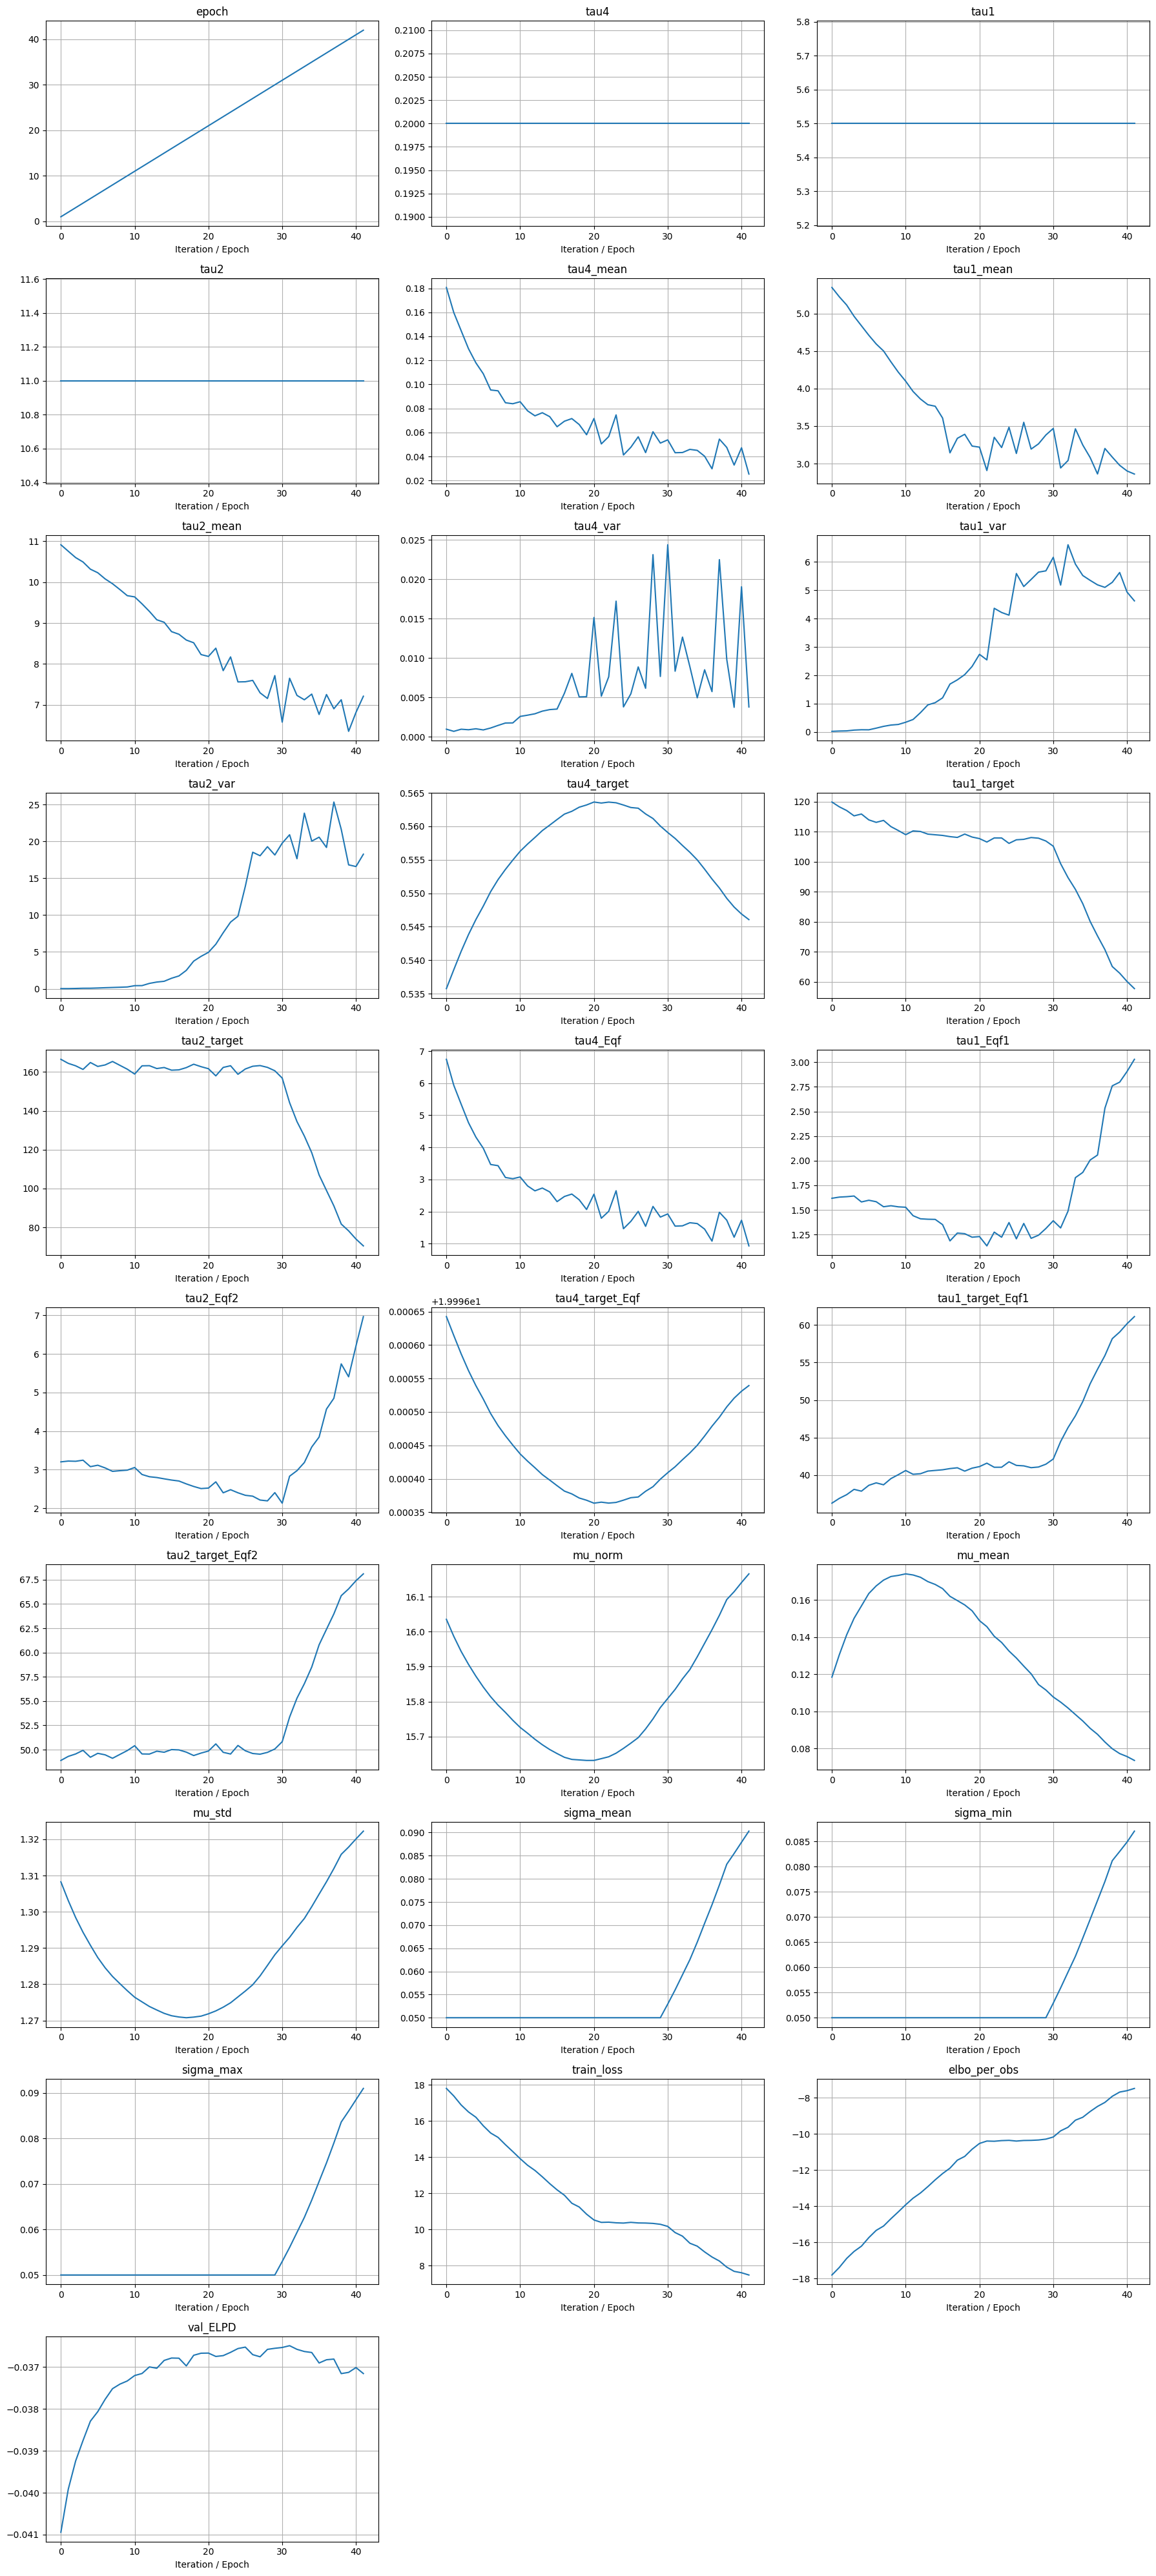

In [24]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [25]:
output["monitor"].keys()

dict_keys(['epoch', 'tau4', 'tau1', 'tau2', 'tau4_mean', 'tau1_mean', 'tau2_mean', 'tau4_var', 'tau1_var', 'tau2_var', 'tau4_target', 'tau1_target', 'tau2_target', 'tau4_Eqf', 'tau1_Eqf1', 'tau2_Eqf2', 'tau4_target_Eqf', 'tau1_target_Eqf1', 'tau2_target_Eqf2', 'mu_norm', 'mu_mean', 'mu_std', 'sigma_mean', 'sigma_min', 'sigma_max', 'train_loss', 'elbo_per_obs', 'val_ELPD'])

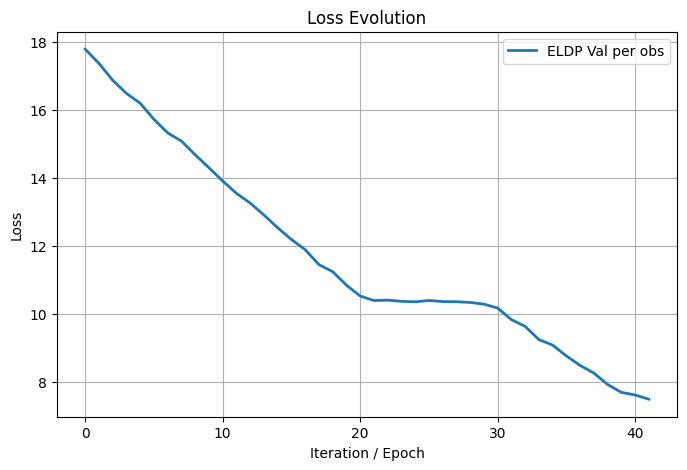

In [26]:

loss_history = output['loss_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [27]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [28]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [29]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0249
KLD GTM      Train Data:  0.0097
KLD Gaussian Train Data:  0.1018
KLD Copula   Train Data:  -0.002

KLD BGTM      Test  Data:  0.0367
KLD GTM      Test  Data:  0.0173
KLD Gaussian Test  Data:  0.1128
KLD Copula   Test  Data:  0.003


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [30]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

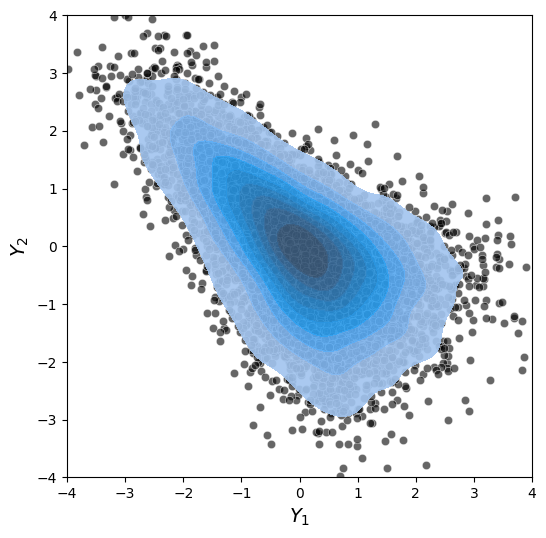

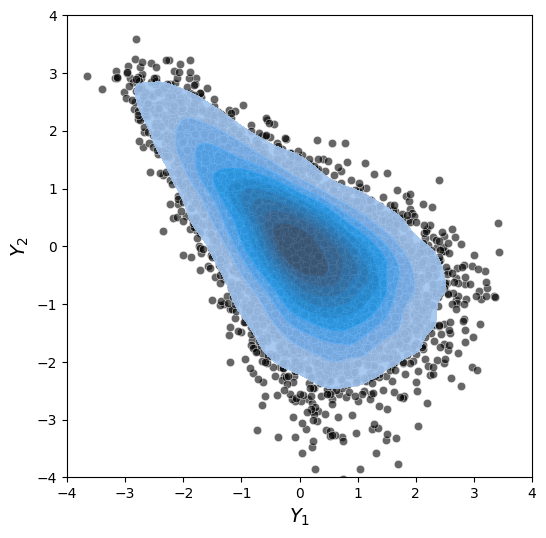

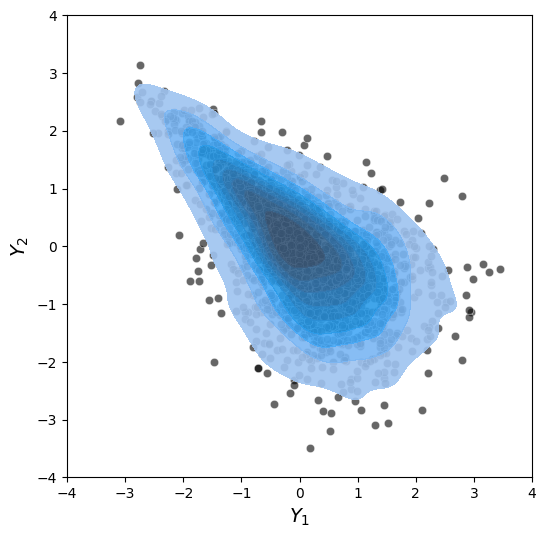

In [31]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [32]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [33]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


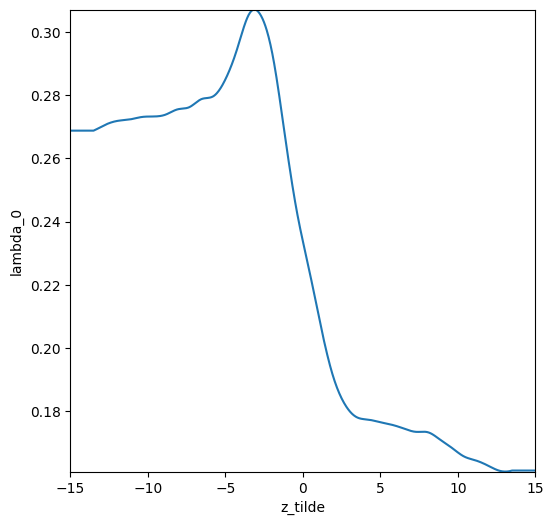

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


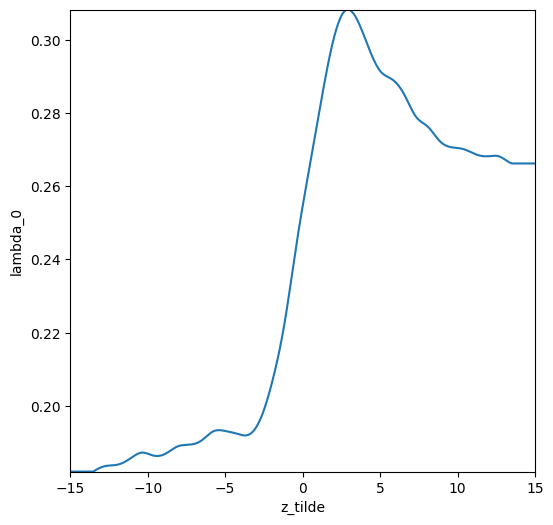

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


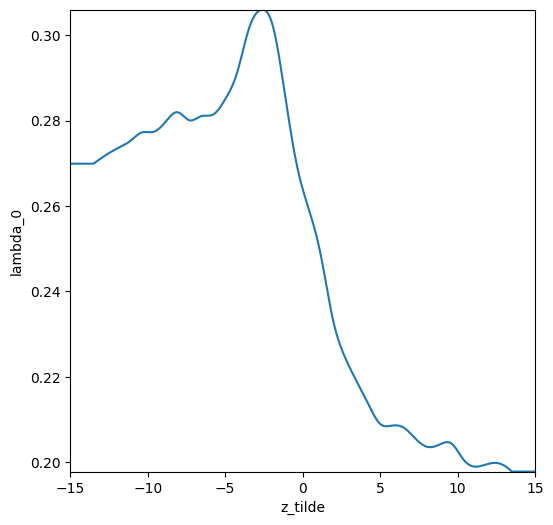

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)